In [54]:
from collections import deque
from random import shuffle
from matplotlib import pyplot as plt
import numpy as np
import torch

def init_grid(size=(10,)):
    grid = torch.randn(*size)
    grid[grid > 0] = 1
    grid[grid <= 0] = 0
    grid = grid.byte()
    return grid

def gen_params(N, size):
    ret = []
    for i in range(N):
        vec = torch.randn(size)/10.
        vec.requires_grad = True
        ret.append(vec)
    return ret

def qfunc(s, theta, layers=[(4, 20), (20, 2)], afn=torch.tanh):
    l1n = layers[0]
    l1s = np.prod(l1n)
    theta_1 = theta[0:l1s].reshape(l1n)
    l2n = layers[1]
    l2s = np.prod(l2n)
    theta_2 = theta[l1s:l1s+l2s].reshape(l2n)
    bias = torch.ones((1, theta_1.shape[1]))
    l1 = torch.nn.functional.elu(s@theta_1 + bias)
    l2 = afn(l1@theta_2)
    return l2.flatten()

def softmax_policy(qvals, temp=0.9):
    soft = torch.exp(qvals / temp)
    soft /= torch.sum(soft)
    action = torch.multinomial(soft, 1)
    return action

def get_coords(grid, j):
    x = int(np.floor(j / grid.shape[0]))
    y = int(j - x * grid.shape[0])
    return x, y

def get_reward_2d(action, action_mean):
    r = (action*(action_mean - action/2)).sum()/action.sum()
    return torch.tanh(5*r)

def get_substate(b):
    s = torch.zeros(2)
    if b > 0:
        s[1] = 1
    else:
        s[0] = 1
    return s

def mean_action(grid, j):
    x, y = get_coords(grid, j)
    action_mean = torch.zeros(2)
    for i in [-1, 0, 1]:
        for k in [-1, 0, 1]:
            if i == k == 0:
                continue
            x_, y_ = x + i, y + k
            x_ = x_ if x_ >= 0 else grid.shape[0] - 1
            y_ = y_ if y_ >= 0 else grid.shape[1] - 1
            x_ = x_ if x_ < grid.shape[0] else 0
            y_ = y_ if y_ < grid.shape[1] else 0
            cur_n = grid[x_, y_]
            s = get_substate(cur_n)
            action_mean += s
            action_mean /= action_mean.sum()
    return action_mean



tensor(55)


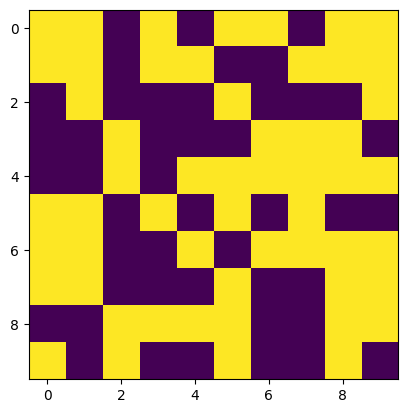

In [69]:
num_states = 2
num_actions = 2
size = (10, 10)
J = np.prod(size)
hid_layer = 40
layers = [(num_actions,hid_layer),
          (hid_layer,num_actions)]
params = gen_params(1,num_states*hid_layer+hid_layer*num_actions)
grid = init_grid(size=size)
grid_ = grid.clone()
grid__ = grid.clone()
plt.imshow(grid)
print(grid.sum())

In [70]:
epochs = 500
lr = 0.0001
num_iter = 3
replay_size = 50
replay = deque(maxlen=replay_size)
batch_size = 10
gamma = 0.98
losses = [[] for i in range(J)]

for i in range(epochs):
    act_means = torch.zeros((J, 2))
    q_next = torch.zeros(J)
    
    for m in range(num_iter):
        for j in range(J):
            action_mean = mean_action(grid_, j).detach()
            act_means[j] = action_mean.clone()
            qvals = qfunc(action_mean.detach(), params[0], layers=layers)
            action = softmax_policy(qvals.detach(), temp=0.5)
            grid_[get_coords(grid_, j)] = action
            q_next[j] = torch.max(qvals).detach()
    
    grid_.data = grid_.data
    grid.data = grid_.data
    actions = torch.stack([get_substate(a.item()) for a in grid.flatten()])
    rewards = torch.stack([get_reward_2d(actions[j], act_means[j]) for j in range(J)])
    # Collects an experience and adds to the experience replay buffer
    exp = (actions, rewards, act_means, q_next)
    replay.append(exp)
    shuffle(replay)

    # Once the experience replay buffer has more experiences than the batch size parameter, starts training
    if len(replay) > batch_size:
        ids = np.random.randint(low=0, high=len(replay), size=batch_size)
        exps = [replay[idx] for idx in ids]
        for j in range(J):
            jacts = torch.stack([ex[0][j] for ex in exps]).detach()
            jrewards = torch.stack([ex[1][j] for ex in exps]).detach()
            jmeans = torch.stack([ex[2][j] for ex in exps]).detach()
            vs = torch.stack([ex[3][j] for ex in exps]).detach()
            qvals = torch.stack([
                qfunc(jmeans[h].detach(), params[0], layers=layers)
                for h in range(batch_size)
            ])
            target = qvals.clone().detach()
            target[:, torch.argmax(jacts, dim=1)] = jrewards + gamma * vs
            loss = torch.sum(torch.pow(qvals - target.detach(), 2))
            losses[j].append(loss.item())
            loss.backward()
            with torch.no_grad():
                params[0] = params[0] - lr * params[0].grad
            params[0].requires_grad = True
    print(f"Epoch: {i}, Loss: {loss.item()}, Grid sum: {grid.sum()}")


Epoch: 0, Loss: 1.3241721391677856, Grid sum: 17
Epoch: 1, Loss: 1.3241721391677856, Grid sum: 20
Epoch: 2, Loss: 1.3241721391677856, Grid sum: 23
Epoch: 3, Loss: 1.3241721391677856, Grid sum: 20
Epoch: 4, Loss: 1.3241721391677856, Grid sum: 17
Epoch: 5, Loss: 1.3241721391677856, Grid sum: 22
Epoch: 6, Loss: 1.3241721391677856, Grid sum: 23
Epoch: 7, Loss: 1.3241721391677856, Grid sum: 22
Epoch: 8, Loss: 1.3241721391677856, Grid sum: 22
Epoch: 9, Loss: 1.3241721391677856, Grid sum: 25
Epoch: 10, Loss: 3.24493670463562, Grid sum: 22
Epoch: 11, Loss: 4.395156383514404, Grid sum: 13
Epoch: 12, Loss: 3.109257221221924, Grid sum: 14
Epoch: 13, Loss: 7.641547203063965, Grid sum: 13
Epoch: 14, Loss: 4.978564262390137, Grid sum: 19
Epoch: 15, Loss: 4.894412994384766, Grid sum: 11
Epoch: 16, Loss: 8.5191068649292, Grid sum: 8
Epoch: 17, Loss: 2.9071483612060547, Grid sum: 15
Epoch: 18, Loss: 4.232031345367432, Grid sum: 17
Epoch: 19, Loss: 2.480046272277832, Grid sum: 12
Epoch: 20, Loss: 5.0969

tensor(36)


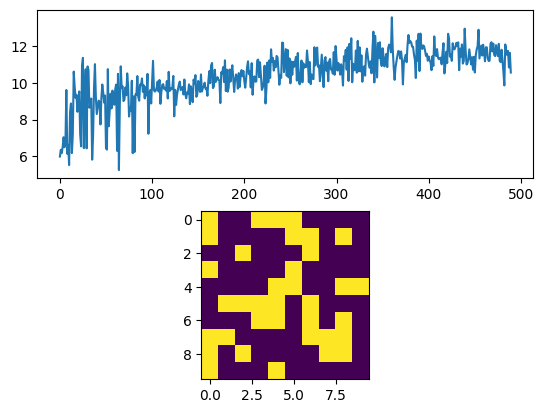

In [71]:
fig,ax = plt.subplots(2,1)
ax[0].plot(np.array(losses).mean(axis=0))
ax[1].imshow(grid)
print(grid.sum())